In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
class Unicycle:
    def __init__(self, x=None,max_linear_velocity=2, max_angular_velocity=np.pi/3):
        if x is None:
            x = np.zeros(3)
        self.x = x
        self.max_linear_velocity = max_linear_velocity
        self.max_angular_velocity = max_angular_velocity 
    
    def f(self, u, x=None, dt=0.1, save_x=True):
        if x is None:
            x = self.x
            
        # clip controls
        u[0] = np.clip(u[0],-self.max_linear_velocity,self.max_linear_velocity)
        u[1] = np.clip(u[1],-self.max_angular_velocity,self.max_angular_velocity)
        
        
        x_prime = x.copy()
        x_prime[0] = x[0] + u[0]*np.cos(x[2])*dt
        x_prime[1] = x[1] + u[0]*np.sin(x[2])*dt
        x_prime[2] = x[2] + u[1]*dt
        
        if save_x:
            self.x = x_prime
        return x_prime
    
    def getA(self, u, x=None, dt=0.1):
        if x is None:
            x = self.x
            
        A = np.eye(3) 
        A[:,2] += np.array([-u[0]*np.sin(x[2])*dt,
                            u[0]*np.cos(x[2])*dt,
                            0])
        return A
        
    def getB(self, x=None, dt=0.1):
        if x is None:
            x = self.x
            
        B = np.zeros((3,2))
        B[0,0] = np.cos(x[2])*dt
        B[1,0] = np.sin(x[2])*dt
        B[2,1] = dt
        return B
        
    def plot(self, x=None, ax=None):
        if x is None:
            x = self.x
            
        if ax is None:
            ax = plt
            
        get_T = lambda x, y, theta: np.array([[np.cos(theta),-np.sin(theta), x], [np.sin(theta),np.cos(theta), y], [0,0,0]])

        def get_point(T, x,y):
            x,y,_ = T@(np.array([[x,y,1]]).T).reshape(-1)
            return x,y

        x,y,theta = x
        T = get_T(x,y,theta)    
        points = [(0.1,0),(0,-0.05),(0,0.05),(0.1,0)]
        points = [get_point(T,*p) for p in points]
        ax.plot([p[0] for p in points], [p[1] for p in points], color='red')


![](imgs/ilqr.png)

In [3]:
def lqr(A, B, T=100):
    V = np.zeros((3,3))
    Q = np.zeros((5,5))
    K = np.zeros((2,3))
    C = np.eye(5)
    F = [A, B]
    for t in range(T):
        
        Q = C + F.T@V@F      
        Q_xx = Q[:3,:3]
        Q_uu = Q[3:,3:]
        Q_ux = Q[3:,:3]
        Q_xu = Q[:3,3:]
        
        K = -np.linalg.inv(Q_uu)@Q_ux
        V = 
    return K

In [4]:
dt = 0.1
x = np.array([0.,0.,0.]) 
xf = np.array([2.000,2.000,np.pi/2])  

track = []
unicycle = Unicycle(x=x)
u = np.zeros(2)

for i in range(200):
    x = unicycle.x
    print(f'iteration = {i}')
    print(f'Current State = {x}')
    print(f'Desired State = {xf}')

    error = x - xf
    track.append(x)
    state_error_magnitude = np.linalg.norm(error)     
    print(f'State Error Magnitude = {state_error_magnitude}')

    B = unicycle.getB(x=x, dt=dt)
    A = unicycle.getA(np.zeros(2), x=x, dt=dt)
    
    K = lqr(A, B) 
    
    # u = ...
    u = K@x
    
    print(f'Control Input = {u}')

    x=unicycle.f(u, x=x, dt=dt)  
    
    if state_error_magnitude < 0.05:
        print(f"\nGoal Has Been Reached Successfully in {i} iterations!")
        break

    print()

iteration = 0
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 1
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 2
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 3
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 4
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 5
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [0. 0.]

iteration = 6
Current State = [0. 0. 0.]

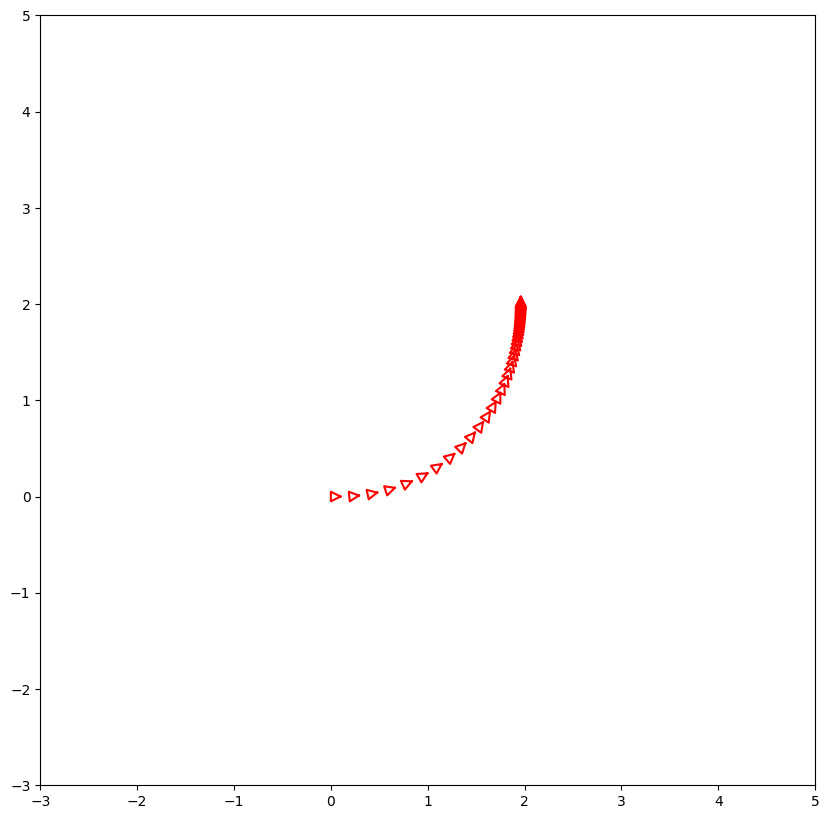

In [19]:
plt.subplots(figsize=(10,10))
plt.xlim(-3,5)
plt.ylim(-3,5)
for x in track:
    unicycle.plot(x)
plt.show()

In [51]:
def lqr_rob(A, B, T=300):
    Q = np.eye(3)
    R = np.eye(2)
    P = np.zeros((3,3))
    for t in range(T):  # ps: don't use t, just run T times
        K = np.zeros((2,3))
        K = -np.linalg.inv(R+B.T@P@B)@B.T@P@A
        P = (Q + K.T@R@K+(A+B@K).T@P@(A+B@K))
    return K, P

In [59]:
dt = 0.1
x = np.array([0.,0.,0.]) 
xf = np.array([2.000,2.000, np.pi/2])  

track = []
unicycle = Unicycle(x=x)
u = np.zeros(2)

for i in range(200):
    x = unicycle.x
    print(f'iteration = {i}')
    print(f'Current State = {x}')
    print(f'Desired State = {xf}')

    error = x - xf
    track.append(x)
    state_error_magnitude = np.linalg.norm(error)     
    print(f'State Error Magnitude = {state_error_magnitude}')

    B = unicycle.getB(x=x, dt=dt)
    A = unicycle.getA(np.zeros(2), x=x, dt=dt)
    
    K, P= lqr_rob(A, B) 
    print(f'K: {K}')
    print(f'P: {P}')

    u = K@error
    
    print(f'Control Input = {u}')

    x=unicycle.f(u, x=x, dt=dt)  
    
    if state_error_magnitude < 0.05:
        print(f"\nGoal Has Been Reached Successfully in {i} iterations!")
        break

    print()

iteration = 0
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 3.095018045856001
K: [[-0.95124922  0.          0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 10.5124922   0.          0.       ]
 [  0.        300.          0.       ]
 [  0.          0.         10.5124922]]
Control Input = [1.90249844 1.19537502]

iteration = 1
Current State = [0.19024984 0.         0.10471976]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 2.932935237595943
K: [[-0.94603818 -0.09943262  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 13.6754905  -30.09391861   0.        ]
 [-30.09391861 296.8370017    0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [1.91095798 1.09576044]

iteration = 2
Current State = [0.3802988  0.01997495 0.20943951]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 2.76415518570302
K: [[-0.93046214 -0.19777583  0.        ]
 [ 0.       

K: [[-0.38723082 -0.86886556  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 252.0287499  -107.63752506    0.        ]
 [-107.63752506   58.4837423     0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [0.34560171 0.09996808]

iteration = 26
Current State = [2.18189203 1.55901053 1.1615425 ]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.48641484406210894
K: [[-0.37852574 -0.87269316  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 254.16132838 -105.68130862    0.        ]
 [-105.68130862   56.35116382    0.        ]
 [   0.            0.           10.5124922 ]]
Control Input = [0.31599768 0.09045862]

iteration = 27
Current State = [2.19446636 1.58800072 1.17058837]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.4636431259790224
K: [[-0.37061609 -0.8760815   0.        ]
 [ 0.          0.         -0.95124922]]
P: [[ 256.05699536 -103.87474786    0.        ]
 [-103.87474786   54.4554

K: [[-0.29973439 -0.90279254  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[271.25817348 -86.56966637   0.        ]
 [-86.56966637  39.25431871   0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [0.0269551  0.00608615]

iteration = 54
Current State = [2.30195629 1.87273081 1.25084761]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.32773245790508904
K: [[-0.29918489 -0.9029748   0.        ]
 [ 0.          0.         -0.95124922]]
P: [[271.36346278 -86.42840117   0.        ]
 [-86.42840117  39.14902942   0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [0.02458012 0.00550721]

iteration = 55
Current State = [2.30272937 1.87506408 1.25139833]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.32753855212754535
K: [[-0.29868755 -0.90313943  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[271.45858818 -86.30046343   0.        ]
 [-86.30046343  39.05390402   0.        ]
 [ 

K: [[-0.2942407  -0.90459797  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.3021095  -85.15292217   0.        ]
 [-85.15292217  38.2103827    0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [0.00165619 0.00030339]

iteration = 84
Current State = [2.31008353 1.89748171 1.25634846]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.3265913009066289
K: [[-0.29421326 -0.9046069   0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.3072762  -85.14581989   0.        ]
 [-85.14581989  38.205216     0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [0.00150807 0.00027453]

iteration = 85
Current State = [2.31013017 1.89762512 1.25637591]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.32659058056207974
K: [[-0.29418842 -0.90461497  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.31195105 -85.13939295   0.        ]
 [-85.13939295  38.20054115   0.        ]
 [  


iteration = 113
Current State = [2.31056931 1.89897598 1.25662116]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.32658711882069164
K: [[-0.29396656 -0.9046871   0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.35369748 -85.08196738   0.        ]
 [-85.08196738  38.15879472   0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [9.81369939e-05 1.51237865e-05]

iteration = 114
Current State = [2.31057234 1.89898531 1.25662267]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.3265871157979405
K: [[-0.29396519 -0.90468754  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.35395483 -85.08161319   0.        ]
 [-85.08161319  38.15853737   0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [8.92715643e-05 1.36851375e-05]

iteration = 115
Current State = [2.3105751  1.8989938  1.25662404]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.3265871132

K: [[-0.29395305 -0.90469148  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.35623813 -85.0784706    0.        ]
 [-85.0784706   38.15625406   0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [6.85980080e-06 9.20750782e-07]

iteration = 142
Current State = [2.31060068 1.89907253 1.25663619]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.32658710140885056
K: [[-0.29395297 -0.90469151  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.3562538  -85.07844903   0.        ]
 [-85.07844903  38.1562384    0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [6.23586735e-06 8.33164436e-07]

iteration = 143
Current State = [2.31060087 1.89907312 1.25663627]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.3265871013967162
K: [[-0.29395289 -0.90469154  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.35626798 -85.07842952   0.        ]
 [-85.07842952  38.15622422 

K: [[-0.29395225 -0.90469175  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.3563893  -85.07826253   0.        ]
 [-85.07826253  38.1561029    0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [6.28611469e-07 7.56585081e-08]

iteration = 167
Current State = [2.3106026  1.89907844 1.25663699]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.3265871013396737
K: [[-0.29395224 -0.90469175  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.35639059 -85.07826076   0.        ]
 [-85.07826076  38.15610161   0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [5.71165307e-07 6.84614984e-08]

iteration = 168
Current State = [2.31060262 1.8990785  1.256637  ]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.32658710133957214
K: [[-0.29395223 -0.90469175  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.35639175 -85.07825916   0.        ]
 [-85.07825916  38.15610044 

K: [[-0.29395218 -0.90469177  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.35640216 -85.07824483   0.        ]
 [-85.07824483  38.15609004   0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [3.52203884e-08 3.77152161e-09]

iteration = 197
Current State = [2.31060278 1.899079   1.25663706]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.3265871013390947
K: [[-0.29395218 -0.90469177  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.35640222 -85.07824474   0.        ]
 [-85.07824474  38.15608997   0.        ]
 [  0.           0.          10.5124922 ]]
Control Input = [3.19872205e-08 3.41275598e-09]

iteration = 198
Current State = [2.31060278 1.89907901 1.25663706]
Desired State = [2.         2.         1.25663706]
State Error Magnitude = 0.3265871013390944
K: [[-0.29395218 -0.90469177  0.        ]
 [ 0.          0.         -0.95124922]]
P: [[272.35640228 -85.07824466   0.        ]
 [-85.07824466  38.15608992  

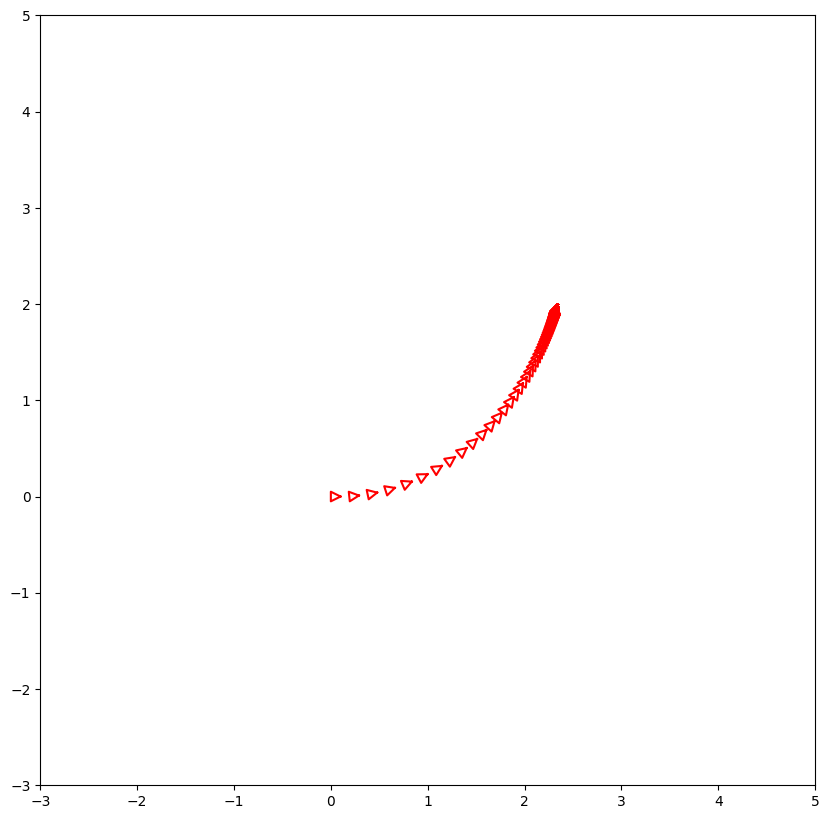

In [60]:
plt.subplots(figsize=(10,10))
plt.xlim(-3,5)
plt.ylim(-3,5)
for x in track:
    unicycle.plot(x)
plt.show()